<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_Finetuning_MPIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1#scrollTo=Wv4afXKj6cVa

##Connect Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/.shortcut-targets-by-id/1tHYgEz3lQF-LmtFPXRgMBDh4UN54qeAs/datas


In [3]:
# !unzip -o ./mpie_30_shuffle.zip -d ./mpie_30_shuffle

In [4]:
!ls

dataCh4_7.mat		iris_shuffle.mat	 mpie_30_shuffle.zip
dataCh4_7.zip		iris.zip		 number_images
digitimages_binary.zip	matlab_iris_shuffle.mat
history_None.png	mpie_30_shuffle


##Load Dataset

In [5]:
from keras.backend import reshape
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column, reshape_flag=False):
  _feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _feature_flatten = _feature_csv.values.flatten()

  reshape_tuple = (_feature_csv.shape[0], 32, 32)
  if reshape_flag:
    reshape_tuple = (_feature_csv.shape[0], 32, 32,-1)
  _feature_reshape = np.reshape(_feature_flatten, reshape_tuple)

  _label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  # print(f'_label_csv : {_label_csv.shape}')
  _label = _label_csv[label_column] # get label you want

  return _feature_reshape, _label

In [6]:
import pandas as pd
import numpy as np


# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0)
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0)

train_feature_reshape.shape, train_label.shape, validation_feature_reshape.shape, validation_label.shape

((18777, 32, 32), (18777,), (5086, 32, 32), (5086,))

In [7]:
np.unique(train_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.], dtype=float32)

In [8]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, normalization=False, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  normal_value = 1
  if normalization:
    normal_value = 255
  _features = features_reshape / normal_value
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [9]:
train_label_length = len(train_label)
print(train_label_length)
batch_size = int(train_label_length / (train_label_length/9))
train_dataset = preprocessDataset(train_feature_reshape, train_label, batch_size=batch_size)
train_dataset

18777


<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [10]:
# train_dataset?
# train_dataset.element_spec
train_dataset.element_spec

(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float32, name=None))

9 3


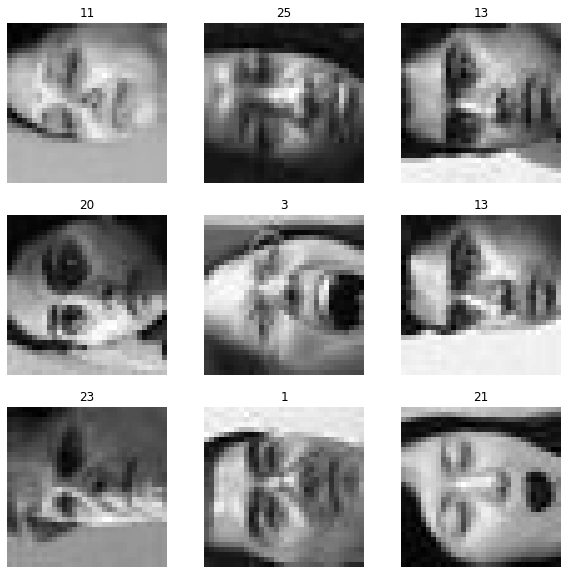

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  batch_count = labels.shape[0]
  rows_cols = int(np.sqrt(batch_count))
  print(batch_count, rows_cols)
  for i in range(batch_count):
    # print(int(labels[i].numpy()))
    ax = plt.subplot(rows_cols, rows_cols, i + 1)
    plt.imshow(images[i].numpy().reshape(32,-1), cmap='gray')
    plt.title(int(labels[i].numpy()))
    plt.axis("off")

In [12]:
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

## Use data augmentation

In [13]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

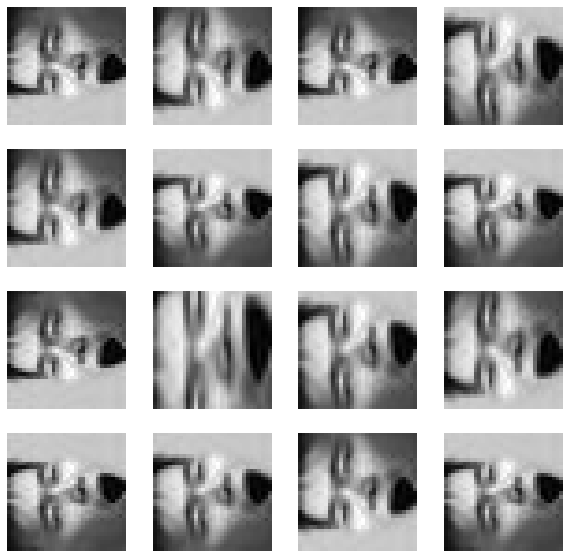

In [15]:
plt.figure(figsize=(10, 10))
for image, _ in train_dataset.take(1):
  first_image = image[0]
  batch_count = 16
  rows_cols = int(np.sqrt(batch_count))
  for i in range(batch_count):
    ax = plt.subplot(rows_cols, rows_cols, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # print(type(augmented_image[0].numpy()))
    plt.imshow(augmented_image[0], cmap='gray')
    plt.axis('off')

##check pre-trained model

In [16]:
# train_feature_reshape.shape[1:]

In [51]:
# Create the base model from the pre-trained model MobileNet V2
image_shape = train_feature_reshape.shape[1:] + (1,)
print(image_shape)

from tensorflow.keras import layers

input_shape = layers.Input(shape=image_shape )
input_concate = tf.keras.layers.Concatenate()([input_shape, input_shape, input_shape]) # model = trained_model (input_tensor=x) 
trained_model = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=True, input_tensor=input_concate) 
trained_model.output

# X = layers.Conv2D(3, kernel_size=3, padding='same')(trained_model.output) 
# X = layers.Activation('tanh')(X) 
# model = tf.keras.models.Model(inputs = input_tensor, outputs = X)
# model

(32, 32, 1)


<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [53]:
image_batch, label_batch = next(iter(train_dataset))
image_batch = tf.expand_dims(image_batch, -1)
image_batch.shape

TensorShape([9, 32, 32, 1])

In [54]:
feature_batch = trained_model(image_batch)
print(feature_batch.shape)

(9, 1000)


In [ ]:
trained_model.trainable = False
# trained_model.summary()

##make model from pre-trained model

In [60]:
class_count = len(train_label.unique())
class_count

30

In [63]:
from tensorflow.keras import layers
trained_model.trainable = True
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

image_shape = (32,32,3)

inputs = layers.Input(shape=image_shape)
input_shape = data_augmentation(inputs)
x = tf.keras.layers.Concatenate()([input_shape, input_shape, input_shape]) # model = trained_model (input_tensor=x) 
# x = trained_model(x, training=False)
x = trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(class_count)(x)

model = tf.keras.Model(inputs, outputs)
model

ValueError: ignored

##callback function for fit time

In [ ]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
TimeHistory()

## fit model

In [ ]:
_epochs = 10
_batch_size = int(len(list(train_dataset)) / (len(list(train_dataset))/2))   # Just Check Model params quickly
# _batch_size = len(list(train_dataset))

def model_fit(_param, _train_dataset, _validation_dataset):
  tf.keras.backend.clear_session()

  model = make_model(**_param)
  time_callback = TimeHistory()
  history = model.fit(_train_dataset, epochs=_param['epochs'], validation_data=_validation_dataset, callbacks=[time_callback], steps_per_epoch=_batch_size)
  execution_time = sum(time_callback.times)
  return model, history, execution_time, _param

In [ ]:
label_class = 0
# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class)
class_cnt = len(np.unique(train_label))
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class)

train_dataset = preprocessDataset(train_feature_reshape, train_label)
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

param = {'_class_cnt':class_cnt, 'epochs':2, 'label_class':label_class, '_kernel_initializer':None
         , '_activation':'sigmoid', 'batch_normal':False, '_optimizer':'RMSprop', 'filters':16 , '_padding':'valid'
         , 'pool_type':'max', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)}

model_fit(param, train_dataset, validation_dataset)

## fit with multi params
filters : larger than 16

In [ ]:
param = {'_class_cnt':class_cnt, 'epochs':2, 'label_class':label_class, '_kernel_initializer':None
         , '_activation':'sigmoid', 'batch_normal':False, '_optimizer':'Nadam', 'filters':16 , '_padding':'same'
         , 'pool_type':'average', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)}


In [ ]:
# param 6
params = list()
param_key_list = list(param.keys())
epochs_list = [10, 50, 100]
_kernel_initializer_list = [None, 'glorot_uniform', 'he_normal']
_activation_list = ['sigmoid', 'relu']
_optimizer_list= ['Adam', 'Nadam']
batch_normal_list = [False, True]
filters_list = [16, 32]
_padding_list = ['same', 'valid']
_kernel_size_list = [(3,3), (5,5)]
_strides_list = [(1,1), (3,3)]
pool_type_list = ['average', 'max']

for filters in filters_list:
  for _padding in _padding_list:
    for _kernel_initializer in _kernel_initializer_list:
      for _activation in _activation_list:
        for _optimizer in _optimizer_list:
          for batch_normal in batch_normal_list:
            for epochs in epochs_list:
              for _kernel_size in _kernel_size_list:
                for _strides in _strides_list:
                  for pool_type in pool_type_list:
                    param_dict = dict()
                    param_dict['filters'] = filters
                    param_dict['_padding'] = _padding
                    param_dict['_kernel_initializer'] = _kernel_initializer
                    param_dict['_activation'] = _activation
                    param_dict['_optimizer'] = _optimizer
                    param_dict['batch_normal'] = batch_normal
                    param_dict['epochs'] = epochs
                    param_dict['_kernel_size'] = _kernel_size
                    param_dict['_strides'] = _strides
                    param_dict['pool_type'] = pool_type
                    # print(param_dict)
                    params.append(param_dict)
len(params)

In [ ]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%m%d%H%M")
print("date and time =", dt_string)

import pickle

In [ ]:
# params = params[5:7]
label_classes = [1, 2, 4]
results_list = list()
for label_class in label_classes:
  train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class)
  class_cnt = len(np.unique(train_label))
  # test
  validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class)

  train_dataset = preprocessDataset(train_feature_reshape, train_label)
  validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

  results = list()          
  for idx, param in enumerate(params):
    param['_class_cnt'] = class_cnt
    param['label_class'] = label_class
    print('-'*5 +'[ '+ str(idx) + ' ]'+ '-'*5 + str(param))
    results.append(model_fit(param, train_dataset, validation_dataset))
  # save
  with open(f'results_CNN_label_{label_class}_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
  results_list = results_list + results


In [ ]:
# save
with open(f'results_CNN_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results_list, f, pickle.HIGHEST_PROTOCOL)